<a href="https://colab.research.google.com/github/myeonghak/VAE_recommender_system/blob/master/VAE_recsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 43kB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 512kB 34.2MB/s 
     |████████████████████████████████| 3.8MB 32.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=429a259c86ad05d532d108e11772c3510986e4b6c4ef370e5ced2fc8d500f454
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [2]:
# https://github.com/dawenl/vae_cf/blob/master/VAE_ML20M_WWW2018.ipynb

# # Variational autoencoders for collaborative filtering 

# This notebook accompanies the paper "*Variational autoencoders for collaborative filtering*" by Dawen Liang, Rahul G. Krishnan, Matthew D. Hoffman, and Tony Jebara, in The Web Conference (aka WWW) 2018.

# In this notebook, we will show a complete self-contained example of training a variational autoencoder (as well as a denoising autoencoder) with multinomial likelihood (described in the paper) on the public Movielens-20M dataset, including both data preprocessing and model training.

import os
import shutil
import sys
import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import pandas as pd

import tensorflow as tf
from tensorflow.contrib.layers import apply_regularization, l2_regularizer

import bottleneck as bn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [123]:
print(f"tensorflow version is :{tf.__version__}")

tensorflow version is :1.15.0




## 데이터 전처리

데이터를 적재하고, 학습/검증/테스트 데이터로 쪼개어줍니다. 

-모든 유저를 학습/검증/테스트 셋으로 나눈다.   
-학습 유저의 전체 클릭 기록으로 모델을 학습한다.  
-모델 평가를 위해, 검증/테스트 유저의 일부 클릭 기록을 뽑아 모델을 위한 유저 수준의 표현을 학습한다.   
-그리고 검증/테스트 유저의 unseen 클릭 기록으로부터 얼마나 모델이 잘 순위를 매기는지를 통해 평가 척도를 계산한다.   

### 'data_path'를 데이터가 있는 위치로 바꿔주세요.

In [4]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [23]:
DATA_DIR  = os.getcwd()

In [24]:
# 데이터 호출
user_purch_list = pd.read_csv("/gdrive/My Drive/VAE_data/ecommerce_data.csv", encoding = 'ISO-8859-1')

In [125]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('CustomerID')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te


### 데이터 분할 과정

-300명의 유저를 유보 고객으로 두고, 300명 유저를 검증용 유저로, 그리고 나머지를 학습용으로 사용  
-학습 유저로부터 나온 모든 아이템을 아이템셋으로 사용  
-검증/테스트 유저 모두에 대해, 80%를 서브샘플하고 fold-in 데이터로 사용, 나머지를 예측에 사용  

In [128]:

# 해당 칼럼의 그룹 사이즈를 출력
def get_count(tp, id_):
    count_groupbyid = tp[[id_]].groupby(id_, as_index=False)
    count = count_groupbyid.size()
    return count

# 5개 미만으로 구매한 고객과 5번 미만으로 판매된 상품은 배제됨.
def filter_triplets(data, min_user_count=5, min_item_count=5):
    
    # Only keep the triplets for items which were clicked on by at least min_sc users.
    
    if min_item_count > 0:
        itemcount = get_count(data, 'StockCode')
        data = data[data['StockCode'].isin(itemcount.index[itemcount >= min_item_count])]
    
    # Only keep the triplets for users who clicked on at least min_user_count items
    # After doing this, some of the items will have less than min_user_count users, but should only be a small proportion
    
    if min_user_count > 0:
        usercount = get_count(data, 'CustomerID')
        data = data[data['CustomerID'].isin(usercount.index[usercount >= min_user_count])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(data, 'CustomerID'), get_count(data, 'StockCode') 
    return data, usercount, itemcount

In [129]:
user_purch_list = user_purch_list.loc[user_purch_list['Quantity'] > 0]
user_purch_list = user_purch_list.loc[user_purch_list['UnitPrice'] > 0]
user_purch_list = user_purch_list.dropna(subset=['CustomerID'])
user_purch_list.CustomerID=user_purch_list.CustomerID.astype(int)

# 필터링을 마친 새로운 raw data와, 유저의 활동 로그, 아이템의 판매 기록을 각각 저장
raw_data, user_activity, item_popularity = filter_triplets(user_purch_list)

# 새로운 raw data로 interaction matrix 계산
pivot=pd.pivot_table(raw_data, values="InvoiceNo",index=["CustomerID"],columns=["StockCode"],aggfunc="count",fill_value=0)

# sparsity는?
sparsity = 1-( 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0]))

print("After filtering, there are %d buying events from %d users and %d items (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 396333 buying events from 4110 users and 3193 items (sparsity: 96.980%)


In [130]:
# 유니크한 유저 아이디를 저장
unique_uid = user_activity.index

# 균일하게 섞어주기 위해 shuffle
np.random.seed(34)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

# 유저의 수를 나누어, train/test를 split함
# 500명의 유저를 hold, 추천 모델 성능 test 용으로 사용

n_users = unique_uid.size
n_heldout_users = 300

tr_users = unique_uid[:(n_users - n_heldout_users* 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

train_purches = user_purch_list.loc[user_purch_list['CustomerID'].isin(tr_users)]
unique_iid = pd.unique(train_purches['StockCode'])

item2id = dict((iid, i) for (i, iid) in enumerate(unique_iid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))


vad_purches = user_purch_list.loc[user_purch_list['CustomerID'].isin(vd_users)]
vad_purches = vad_purches.loc[vad_purches['StockCode'].isin(unique_iid)]

vad_purches_tr, vad_purches_te = split_train_test_proportion(vad_purches)

test_purches = user_purch_list.loc[user_purch_list['CustomerID'].isin(te_users)]
test_purches = test_purches.loc[test_purches['StockCode'].isin(unique_iid)]
test_purches_tr, test_purches_te = split_train_test_proportion(test_purches)

0 users sampled
0 users sampled


In [131]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['CustomerID']))
    iid = list(map(lambda x: item2id[x], tp['StockCode']))
    return pd.DataFrame(data={'uid': uid, 'iid': iid}, columns=['uid', 'iid'])


train_purches = numerize(train_purches)
vad_purches_tr = numerize(vad_purches_tr)
vad_purches_te = numerize(vad_purches_te)

test_purches_tr = numerize(test_purches_tr)
test_purches_te = numerize(test_purches_te)

n_items = len(unique_iid.tolist())

def process_data(dataframe):
    n_users = dataframe['uid'].max() + 1

    rows, cols = dataframe['uid'], dataframe['iid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [132]:
train_purches = process_data(train_purches)

vad_purches_tr = process_data(vad_purches_tr)
vad_purches_te = process_data(vad_purches_te)

test_purches_tr = process_data(test_purches_tr)
test_purches_te = process_data(test_purches_te)

In [137]:

n_items = len(unique_iid)
N = train_purches.shape[0]
idxlist = range(N)

# training batch size
batch_size = 100
batches_per_epoch = int(np.ceil(float(N) / batch_size))

N_vad = vad_purches_tr.shape[0]
idxlist_vad = range(N_vad)

# validation batch size (since the entire validation set might not fit into GPU memory)
batch_size_vad = 100

# the total number of gradient updates for annealing
total_anneal_steps = 200000
# largest annealing parameter
anneal_cap = 0.2


In [138]:
class MultiDAE(object):
    def __init__(self, p_dims, q_dims=None, lam=0.01, lr=1e-3, random_seed=None):
        self.p_dims = p_dims
        if q_dims is None:
            self.q_dims = p_dims[::-1]
            
        else:
            assert q_dims[0] == p_dims[-1], "Input and output dimension must equal each other for autoencoders."
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q-network mismatches."
            self.q_dims = q_dims
        self.dims = self.q_dims + self.p_dims[1:]
        
        self.lam = lam
        self.lr = lr
        self.random_seed = random_seed

        self.construct_placeholders()

    def construct_placeholders(self):        
        self.input_ph = tf.placeholder(
            dtype=tf.float32, shape=[None, self.dims[0]])
        self.keep_prob_ph = tf.placeholder_with_default(1.0, shape=None)

    def build_graph(self):

        self.construct_weights()

        saver, logits = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        # per-user average negative log-likelihood
        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph, axis=1))
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        reg_var = apply_regularization(reg, self.weights)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        loss = neg_ll + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('loss', loss)
        merged = tf.summary.merge_all()
        return saver, logits, loss, train_op, merged

    def forward_pass(self):
        # construct forward graph        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights) - 1:
                h = tf.nn.tanh(h)
        return tf.train.Saver(), h

    def construct_weights(self):

        self.weights = []
        self.biases = []
        
        # define weights
        for i, (d_in, d_out) in enumerate(zip(self.dims[:-1], self.dims[1:])):
            weight_key = "weight_{}to{}".format(i, i+1)
            bias_key = "bias_{}".format(i+1)
            
            self.weights.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights[-1])
            tf.summary.histogram(bias_key, self.biases[-1])



In [139]:
class MultiVAE(MultiDAE):

    def construct_placeholders(self):
        super(MultiVAE, self).construct_placeholders()

        # placeholders with default values when scoring
        self.is_training_ph = tf.placeholder_with_default(0., shape=None)
        self.anneal_ph = tf.placeholder_with_default(1., shape=None)
        
    def build_graph(self):
        self._construct_weights()

        saver, logits, KL = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph,
            axis=-1))
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        
        reg_var = apply_regularization(reg, self.weights_q + self.weights_p)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        neg_ELBO = neg_ll + self.anneal_ph * KL + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(neg_ELBO)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('KL', KL)
        tf.summary.scalar('neg_ELBO_train', neg_ELBO)
        merged = tf.summary.merge_all()

        return saver, logits, neg_ELBO, train_op, merged
    
    def q_graph(self):
        mu_q, std_q, KL = None, None, None
        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights_q, self.biases_q)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_q) - 1:
                h = tf.nn.tanh(h)
            else:
                mu_q = h[:, :self.q_dims[-1]]
                logvar_q = h[:, self.q_dims[-1]:]

                std_q = tf.exp(0.5 * logvar_q)
                KL = tf.reduce_mean(tf.reduce_sum(
                        0.5 * (-logvar_q + tf.exp(logvar_q) + mu_q**2 - 1), axis=1))
        return mu_q, std_q, KL

    def p_graph(self, z):
        h = z
        
        for i, (w, b) in enumerate(zip(self.weights_p, self.biases_p)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_p) - 1:
                h = tf.nn.tanh(h)
        return h

    def forward_pass(self):
        # q-network
        mu_q, std_q, KL = self.q_graph()
        epsilon = tf.random_normal(tf.shape(std_q))

        sampled_z = mu_q + self.is_training_ph *\
            epsilon * std_q

        # p-network
        logits = self.p_graph(sampled_z)
        
        return tf.train.Saver(), logits, KL

    def _construct_weights(self):
        self.weights_q, self.biases_q = [], []
        
        for i, (d_in, d_out) in enumerate(zip(self.q_dims[:-1], self.q_dims[1:])):
            if i == len(self.q_dims[:-1]) - 1:
                # we need two sets of parameters for mean and variance,
                # respectively
                d_out *= 2
            weight_key = "weight_q_{}to{}".format(i, i+1)
            bias_key = "bias_q_{}".format(i+1)
            
            self.weights_q.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_q.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_q[-1])
            tf.summary.histogram(bias_key, self.biases_q[-1])
            
        self.weights_p, self.biases_p = [], []

        for i, (d_in, d_out) in enumerate(zip(self.p_dims[:-1], self.p_dims[1:])):
            weight_key = "weight_p_{}to{}".format(i, i+1)
            bias_key = "bias_p_{}".format(i+1)
            self.weights_p.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_p.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_p[-1])
            tf.summary.histogram(bias_key, self.biases_p[-1])

In [140]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

In [141]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))

    return recall

In [142]:
p_dims = [200, 600, n_items]
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
# ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
# ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
# merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

INFO:tensorflow:Scale of 0 disables regularizer.


In [143]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))
log_dir = '/volmount/log/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

log directory: /volmount/log/ml-20m/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I


In [144]:
chkpt_dir = '/volmount/chkpt/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /volmount/chkpt/ml-20m/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I


In [145]:
Idxlist=list(idxlist)
Idxlist_vad=list(idxlist_vad)

In [146]:
n_epochs = 200
ndcgs_vad = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf

    update_count = 0.0
    
    for epoch in range(n_epochs):
      print(epoch)
      np.random.shuffle(Idxlist)
      # train for one epoch
      for bnum, st_idx in enumerate(range(0, N, batch_size)):
          end_idx = min(st_idx + batch_size, N)
          X = train_purches[Idxlist[st_idx:end_idx]]
            
          if sparse.isspmatrix(X):
              X = X.toarray()
          X = X.astype('float32')           
            
          if total_anneal_steps > 0:
              anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
          else:
              anneal = anneal_cap
           
          feed_dict = {vae.input_ph: X, 
                       vae.keep_prob_ph: 0.5, 
                       vae.anneal_ph: anneal,
                       vae.is_training_ph: 1}        
          sess.run(train_op_var, feed_dict=feed_dict)
          
          if bnum % 100 == 0:
            summary_train = sess.run(merged_var, feed_dict=feed_dict)
            summary_writer.add_summary(summary_train, 
                                         global_step=epoch * batches_per_epoch + bnum) 
            
          update_count += 1
        
        # compute validation NDCG
      ndcg_dist = []
      for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
          end_idx = min(st_idx + batch_size_vad, N_vad)
          X = vad_purches_tr[Idxlist_vad[st_idx:end_idx]]

          if sparse.isspmatrix(X):
              X = X.toarray()
          X = X.astype('float32')
        
          pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
            # exclude examples from training and validation (if any)
          pred_val[X.nonzero()] = -np.inf
          ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_purches_te[Idxlist_vad[st_idx:end_idx]]))
        
      ndcg_dist = np.concatenate(ndcg_dist)
      ndcg_ = np.nanmean(ndcg_dist)
      ndcgs_vad.append(ndcg_)
    #   merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
    #   summary_writer.add_summary(merged_valid_val, epoch)

        # update the best model (if necessary)
      if ndcg_ > best_ndcg:
          saver.save(sess, '{}/model'.format(chkpt_dir))
          best_ndcg = ndcg_

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


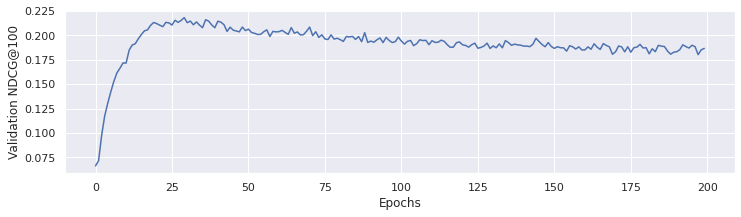

In [147]:

plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

In [148]:

N_test = test_purches_tr.shape[0]
idxlist_test = range(N_test)
Idxlist_test=list(idxlist)

batch_size_test = 2000

In [149]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0)
saver, logits_var, _, _, _ = vae.build_graph()

INFO:tensorflow:Scale of 0 disables regularizer.


In [150]:
chkpt_dir = '/volmount/chkpt/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /volmount/chkpt/ml-20m/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I


In [151]:
n100_list, r20_list, r50_list = [], [], []

with tf.Session() as sess:
    # saver.restore(sess, '{}/model'.format(chkpt_dir))
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_purches_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X})
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_purches_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val, test_purches_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_purches_te[idxlist_test[st_idx:end_idx]], k=50))
    
n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [152]:
holdout=test_purches_te[idxlist_test[st_idx:end_idx]].todense()

In [153]:
print("Test NDCG@100=%.5f (%.5f)" % (np.nanmean(n100_list), np.nanstd(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20=%.5f (%.5f)" % (np.nanmean(r20_list), np.nanstd(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50=%.5f (%.5f)" % (np.nanmean(r50_list), np.nanstd(r50_list) / np.sqrt(len(r50_list))))

Test NDCG@100=0.00953 (0.00039)
Test Recall@20=0.00484 (0.00034)
Test Recall@50=0.00804 (0.00047)


In [154]:
p_dims = [200, n_items]


In [155]:
tf.reset_default_graph()
dae = MultiDAE(p_dims, lam=0.01 / batch_size, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var = dae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
# ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
# merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

In [156]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in dae.dims[1:-1]]))


In [157]:

log_dir = '/volmount/log/ml-20m/DAE/{}'.format(arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

log directory: /volmount/log/ml-20m/DAE/I-200-I


In [158]:
chkpt_dir = '/volmount/chkpt/ml-20m/DAE/{}'.format(arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /volmount/chkpt/ml-20m/DAE/I-200-I


In [159]:
# Idxlist=list(idxlist)


In [160]:
n_epochs = 200
ndcgs_vad = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf
    
    for epoch in range(n_epochs):
        np.random.shuffle(Idxlist)
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_purches[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            feed_dict = {dae.input_ph: X, 
                         dae.keep_prob_ph: 0.5}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, global_step=epoch * batches_per_epoch + bnum) 
                    
        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_purches_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_val = sess.run(logits_var, feed_dict={dae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_purches_te[idxlist_vad[st_idx:end_idx]]))
        
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = np.nanmean(ndcg_dist)
        ndcgs_vad.append(ndcg_)
        # merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        # summary_writer.add_summary(merged_valid_val, epoch)

        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


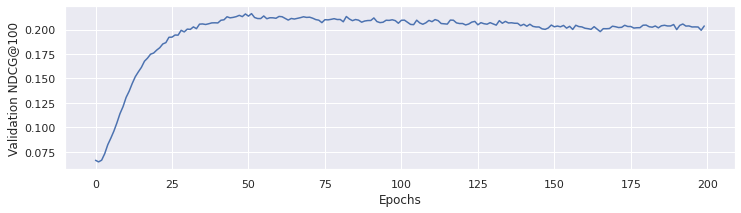

In [161]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

In [162]:
tf.reset_default_graph()
dae = MultiDAE(p_dims, lam=0.01 / batch_size)
saver, logits_var, _, _, _ = dae.build_graph()

In [163]:
n100_list, r20_list, r50_list = [], [], []

with tf.Session() as sess:    
    # saver.restore(sess, '{}/model'.format(chkpt_dir))
    init = tf.global_variables_initializer()
    sess.run(init)
    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_purches_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={dae.input_ph: X})
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_purches_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val, test_purches_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_purches_te[idxlist_test[st_idx:end_idx]], k=50))

n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [164]:

print("Test NDCG@100=%.5f (%.5f)" % (np.nanmean(n100_list), np.nanstd(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20=%.5f (%.5f)" % (np.nanmean(r20_list), np.nanstd(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50=%.5f (%.5f)" % (np.nanmean(r50_list), np.nanstd(r50_list) / np.sqrt(len(r50_list))))

Test NDCG@100=0.00992 (0.00051)
Test Recall@20=0.00465 (0.00052)
Test Recall@50=0.01366 (0.00115)
